In [363]:
import os
from pathlib import Path
import pandas as pd
import hvplot.pandas
import yfinance as yf
import sklearn.ensemble as ml
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import OpenBlender
import json
import numpy as np
import pyspark
from pyspark.sql import SparkSession
%matplotlib inline

# ETF Data using Yahoo Finance

In [364]:
csvpath = Path('Resources/Tickers.csv')

ticker = pd.read_csv(csvpath, header=None)

In [365]:
etfs = ticker[0].values


In [366]:
def getData(ticker):

    tickerData = yf.Ticker(ticker)
    
    tickerData_history = tickerData.history(period="max")
    
    tickerData_history = tickerData_history[tickerData_history.index > '2016-01-01']
        
    return tickerData_history 


In [367]:
etf_df = pd.DataFrame()

for etf in etfs:
        
    hist = getData(etf)
    
    etf_df[etf] = hist["Close"]    

- ISBT: No data found, symbol may be delisted
- VQN: 1d data not available for startTime=-2208988800 and endTime=1623283466. Only 100 years worth of day granularity data are allowed to be fetched per request.


In [368]:
#Cleanup
#Get Tickers that have Nulls
nullseries = etf_df.isnull().sum()
print(nullseries[nullseries > 0])

XGD.TO      26
ZTL.NE     313
XST.TO      26
ISBT      1368
VRE        471
BBU        103
VQN       1368
FTXR       182
FTL       1222
dtype: int64


In [369]:
#Drop the above tickers

etf_df.drop(["XGD.TO","ZTL.NE","XST.TO","ISBT",
             "VRE","BBU","VQN","FTXR","FTL"], axis=1, inplace=True)



In [370]:
etf_df

,TAN,QCLN,XLE,ICLN,AMLP,VDE,XOP,IEMG,IVV,VOO,...,MCO,COMT,IYK,PSL,IEV,VDC,FSTA,KXI,RHS,PBJ
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,28.486816,15.180246,48.018921,8.728479,37.319801,69.563927,112.901924,33.782635,183.012726,166.546982,...,91.433571,23.346825,95.186722,53.006512,34.409489,111.413399,26.111456,40.639130,102.862846,29.590296
2016-01-05,28.051689,15.247247,48.202087,8.692670,37.074284,69.815010,112.530151,33.861835,183.393204,166.845139,...,92.703247,23.124161,95.525612,53.559555,34.191772,112.069267,26.295403,40.741112,103.491974,29.796633
2016-01-06,27.505468,14.873962,46.346638,8.558387,34.956619,67.103081,104.797661,33.254646,180.992325,164.730637,...,91.047974,22.579866,94.633766,53.378376,33.616966,111.597046,26.216570,40.381947,103.141457,29.684082
2016-01-07,24.987297,14.108252,45.215832,8.245056,33.084499,65.429077,102.195374,32.251461,176.661652,160.718582,...,87.201401,22.233500,92.751976,52.482071,33.007336,110.162827,25.866196,39.854275,101.766373,29.224522
2016-01-08,25.274294,14.041251,44.634518,8.164486,33.728996,64.600418,102.678673,31.943466,174.704666,159.010727,...,84.718544,22.101549,91.904747,52.205551,32.676388,109.305809,25.673492,39.535027,101.101288,29.055700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,75.559998,61.560001,55.380001,22.090000,35.880001,77.480003,96.449997,67.379997,420.410004,385.010010,...,334.279999,33.580002,179.869995,97.510002,54.959999,186.110001,43.480000,62.209999,166.410004,43.840000
2021-06-04,76.839996,62.590000,55.750000,22.299999,35.980000,78.050003,96.419998,68.040001,424.239990,388.500000,...,335.649994,33.959999,181.600006,97.199997,55.389999,186.679993,43.590000,62.619999,166.830002,43.910000
2021-06-07,76.559998,63.410000,55.509998,22.420000,36.700001,77.769997,97.349998,67.739998,423.880005,388.170013,...,335.070007,34.020000,181.940002,97.790001,55.639999,186.559998,43.590000,62.639999,166.399994,44.070000


In [371]:
#Pct Change
etf_returns = etf_df.pct_change()

cumulative_returns = (1+etf_returns).cumprod()

#cumulative_returns.plot(figsize=(20, 20))


In [372]:
cumulative_returns.hvplot(label='Cumulative Returns', xlabel='Year', ylabel='Percent', height=400, width=1024)


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

# COVID Data using CSV 

In [373]:
def getCovidData(csv):
    
    csvpath = Path('Resources/COVID_Data/' + csv)
    data = pd.read_csv(csvpath, index_col="Day")
    
    cleaned_data = data.loc[data['Code'] == 'USA'].drop(columns=['Entity', 'Code'])
    
    return cleaned_data

In [374]:
testing_pol = getCovidData('covid-19-testing-policy.csv')
contact_tr = getCovidData('covid-contact-tracing.csv')
vax_pol = getCovidData('covid-vaccination-policy.csv')
debt_relief = getCovidData('debt-relief-covid.csv')
face_cover = getCovidData('face-covering-policies-covid.csv')
income_support = getCovidData('income-support-covid.csv')
internal_mov = getCovidData('internal-movement-covid.csv')
int_travel = getCovidData('international-travel-covid.csv')
public_camp = getCovidData('public-campaigns-covid.csv')
public_events = getCovidData('public-events-covid.csv')
public_gather = getCovidData('public-gathering-rules-covid.csv')
public_trans = getCovidData('public-transport-covid.csv')
stay_home = getCovidData('stay-at-home-covid.csv')
work_close = getCovidData('workplace-closures-covid.csv')
school_close = getCovidData('school-closures-covid.csv')
stringency = getCovidData('covid-stringency-index.csv')

covid_data = pd.concat([testing_pol, contact_tr, vax_pol, debt_relief, face_cover, income_support, internal_mov,
                       int_travel, public_camp, public_events, public_gather, public_trans, stay_home, work_close,
                       school_close, stringency
                       ], axis="columns", join="outer")


covid_data

,testing_policy,contact_tracing,vaccination_policy,debt_relief,facial_coverings,income_support,restrictions_internal_movements,international_travel_controls,public_information_campaigns,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,workplace_closures,school_closures,stringency_index
Day,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-19,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-20,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31


In [375]:
covid_data.isnull().sum()

testing_policy                      0
contact_tracing                     0
vaccination_policy                  0
debt_relief                         0
facial_coverings                    0
income_support                      0
restrictions_internal_movements     0
international_travel_controls       0
public_information_campaigns        0
cancel_public_events                0
restriction_gatherings              0
close_public_transport              0
stay_home_requirements              0
workplace_closures                  0
school_closures                    20
stringency_index                   20
dtype: int64

In [376]:
#Replace nulls with 0s, in this case Null values are where there is either no data or N/A hence, 0.
covid_data['school_closures'] = covid_data['school_closures'].fillna(0)
covid_data['stringency_index'] = covid_data['stringency_index'].fillna(0)


In [377]:
covid_data.isnull().sum()

testing_policy                     0
contact_tracing                    0
vaccination_policy                 0
debt_relief                        0
facial_coverings                   0
income_support                     0
restrictions_internal_movements    0
international_travel_controls      0
public_information_campaigns       0
cancel_public_events               0
restriction_gatherings             0
close_public_transport             0
stay_home_requirements             0
workplace_closures                 0
school_closures                    0
stringency_index                   0
dtype: int64

In [378]:
#Mapping COVID Data to 0 or 1 based on its impact , at No Impact is 0 and Impactful at 1

def Mapper(x): 
    if x >= 2:
        return 1
    else :
        return 0
       

In [379]:
covid_data = covid_data.applymap(lambda x:Mapper(x))

In [380]:
covid_data

,testing_policy,contact_tracing,vaccination_policy,debt_relief,facial_coverings,income_support,restrictions_internal_movements,international_travel_controls,public_information_campaigns,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,workplace_closures,school_closures,stringency_index
Day,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2021-05-19,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2021-05-20,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1


## Signals

In [381]:
# Change Signal

sig_df = pd.DataFrame(index=etf_returns.index)

sig_df['Close'] = etf_df['SPGI']
sig_df['daily_return'] = etf_returns['SPGI']

In [382]:
### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
sig_df['fast_close'] = sig_df['Close'].ewm(halflife=short_window).mean()
sig_df['slow_close'] = sig_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
sig_df['crossover_long'] = np.where(sig_df['fast_close'] > sig_df['slow_close'], 1.0, 0.0)
sig_df['crossover_short'] = np.where(sig_df['fast_close'] < sig_df['slow_close'], -1.0, 0.0)
sig_df['crossover_signal'] = sig_df['crossover_long'] + sig_df['crossover_short']

sig_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
2016-01-04,89.493141,NaN,89.493141,89.493141,0.0,0.0,0.0
2016-01-05,89.795204,0.003375,89.694516,89.649405,1.0,0.0,1.0
2016-01-06,88.813446,-0.010933,89.191048,89.351230,0.0,-1.0,-1.0
2016-01-07,86.019112,-0.031463,87.499348,88.429695,0.0,-1.0,-1.0
2016-01-08,83.555260,-0.028643,85.463690,87.315206,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...
2021-06-03,381.350006,0.004002,379.739307,377.260469,1.0,0.0,1.0
2021-06-04,384.579987,0.008470,382.159647,377.750635,1.0,0.0,1.0
2021-06-07,381.230011,-0.008711,381.694829,377.983638,1.0,0.0,1.0


In [413]:
### Plot Exponential Moving Average of Closing Prices
sig_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

KeyError: "None of [Index(['Close', 'fast_close', 'slow_close'], dtype='object')] are in the [columns]"

In [383]:
#sig_df[['crossover_signal']]

sig_df['crossover_toggle'] = sig_df.groupby((sig_df['crossover_signal'] != sig_df['crossover_signal'].shift(1)).cumsum()).cumcount()+1

sig_df[['crossover_signal', 'crossover_toggle']]



,crossover_signal,crossover_toggle
Date,,
2016-01-04,0.0,1
2016-01-05,1.0,1
2016-01-06,-1.0,1
2016-01-07,-1.0,2
2016-01-08,-1.0,3
...,...,...
2021-06-03,1.0,2
2021-06-04,1.0,3
2021-06-07,1.0,4


In [384]:
sig_df['crossover_real'] = np.where(sig_df['crossover_toggle'] == 1, sig_df['crossover_signal'], 0)

<AxesSubplot:xlabel='Date'>

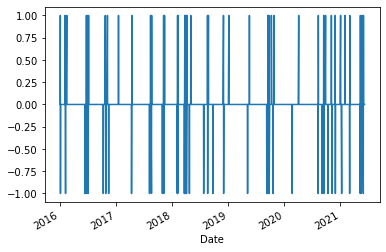

In [385]:
sig_df['crossover_real'].plot()

<AxesSubplot:xlabel='Date'>

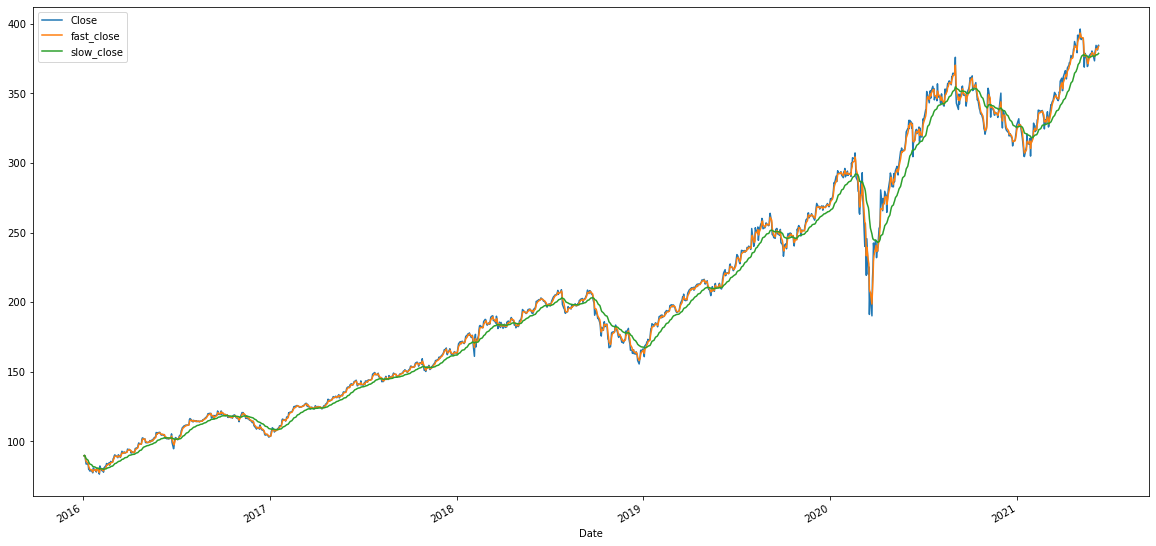

In [386]:
### Plot Exponential Moving Average of Closing Prices
sig_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [387]:
### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
sig_df['fast_vol'] = sig_df['daily_return'].ewm(halflife=short_vol_window).std()
sig_df['slow_vol'] = sig_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
sig_df['vol_trend_long'] = np.where(sig_df['fast_vol'] < sig_df['slow_vol'], 1.0, 0.0)
sig_df['vol_trend_short'] = np.where(sig_df['fast_vol'] > sig_df['slow_vol'], -1.0, 0.0) 
sig_df['vol_trend_signal'] = sig_df['vol_trend_long'] + sig_df['vol_trend_short']

sig_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,crossover_toggle,crossover_real,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,
2016-01-04,89.493141,NaN,89.493141,89.493141,0.0,0.0,0.0,1,0.0,NaN,NaN,0.0,0.0,0.0
2016-01-05,89.795204,0.003375,89.694516,89.649405,1.0,0.0,1.0,1,1.0,NaN,NaN,0.0,0.0,0.0
2016-01-06,88.813446,-0.010933,89.191048,89.351230,0.0,-1.0,-1.0,1,-1.0,0.010118,0.010118,0.0,0.0,0.0
2016-01-07,86.019112,-0.031463,87.499348,88.429695,0.0,-1.0,-1.0,2,0.0,0.017562,0.017576,1.0,0.0,1.0
2016-01-08,83.555260,-0.028643,85.463690,87.315206,0.0,-1.0,-1.0,3,0.0,0.012567,0.016047,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,381.350006,0.004002,379.739307,377.260469,1.0,0.0,1.0,2,0.0,0.011947,0.012161,1.0,0.0,1.0
2021-06-04,384.579987,0.008470,382.159647,377.750635,1.0,0.0,1.0,3,0.0,0.008823,0.011905,1.0,0.0,1.0
2021-06-07,381.230011,-0.008711,381.694829,377.983638,1.0,0.0,1.0,4,0.0,0.011156,0.011782,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

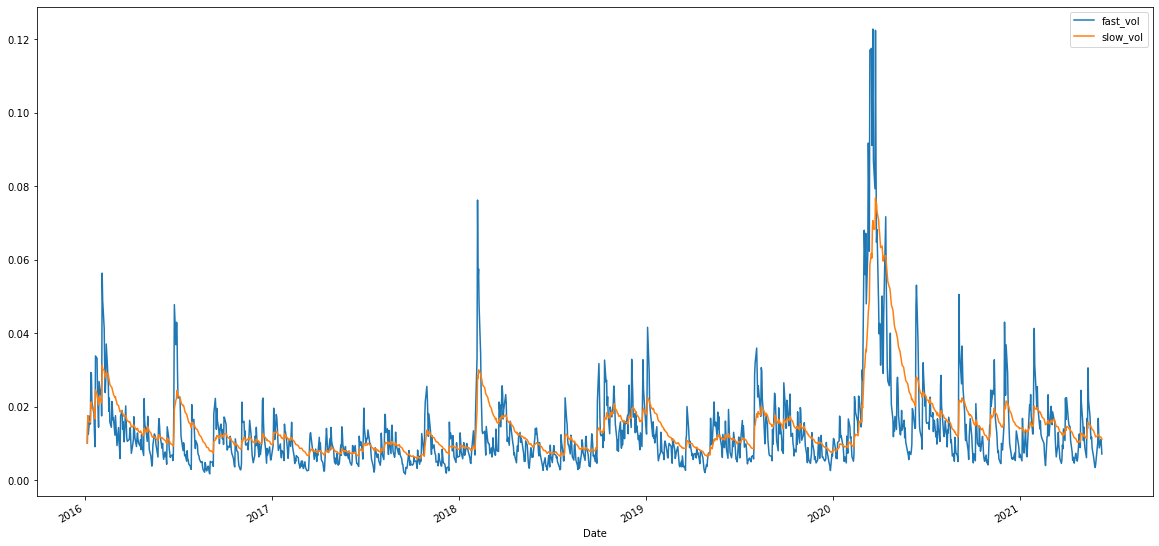

In [388]:
### Plot Exponential Moving Average of Daily Return Volatility
sig_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,crossover_toggle,crossover_real,fast_vol,...,vol_trend_long,vol_trend_short,vol_trend_signal,closing_rollingmean20,closing_rollingstd20,closing_bollinger_upper,closing_bollinger_lower,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,89.493141,NaN,89.493141,89.493141,0.0,0.0,0.0,1,0.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0
2016-01-05,89.795204,0.003375,89.694516,89.649405,1.0,0.0,1.0,1,1.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0
2016-01-06,88.813446,-0.010933,89.191048,89.351230,0.0,-1.0,-1.0,1,-1.0,0.010118,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0
2016-01-07,86.019112,-0.031463,87.499348,88.429695,0.0,-1.0,-1.0,2,0.0,0.017562,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0,0,0
2016-01-08,83.555260,-0.028643,85.463690,87.315206,0.0,-1.0,-1.0,3,0.0,0.012567,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,381.350006,0.004002,379.739307,377.260469,1.0,0.0,1.0,2,0.0,0.011947,...,1.0,0.0,1.0,378.379204,6.033103,390.445409,366.312999,0,0,0
2021-06-04,384.579987,0.008470,382.159647,377.750635,1.0,0.0,1.0,3,0.0,0.008823,...,1.0,0.0,1.0,378.169272,5.716958,389.603187,366.735356,0,0,0
2021-06-07,381.230011,-0.008711,381.694829,377.983638,1.0,0.0,1.0,4,0.0,0.011156,...,1.0,0.0,1.0,377.734956,5.071027,387.877009,367.592903,0,0,0


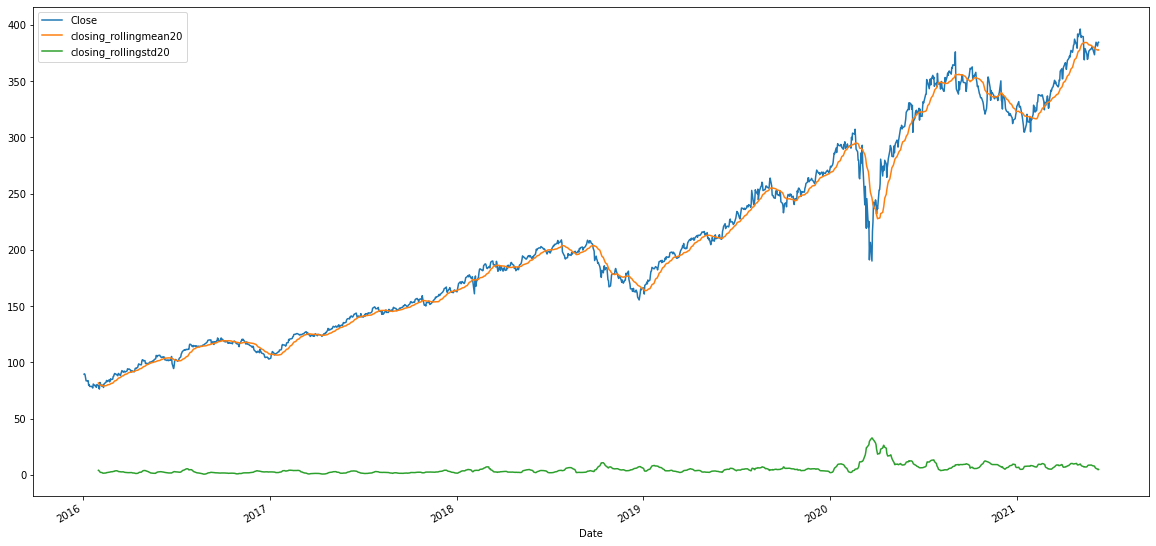

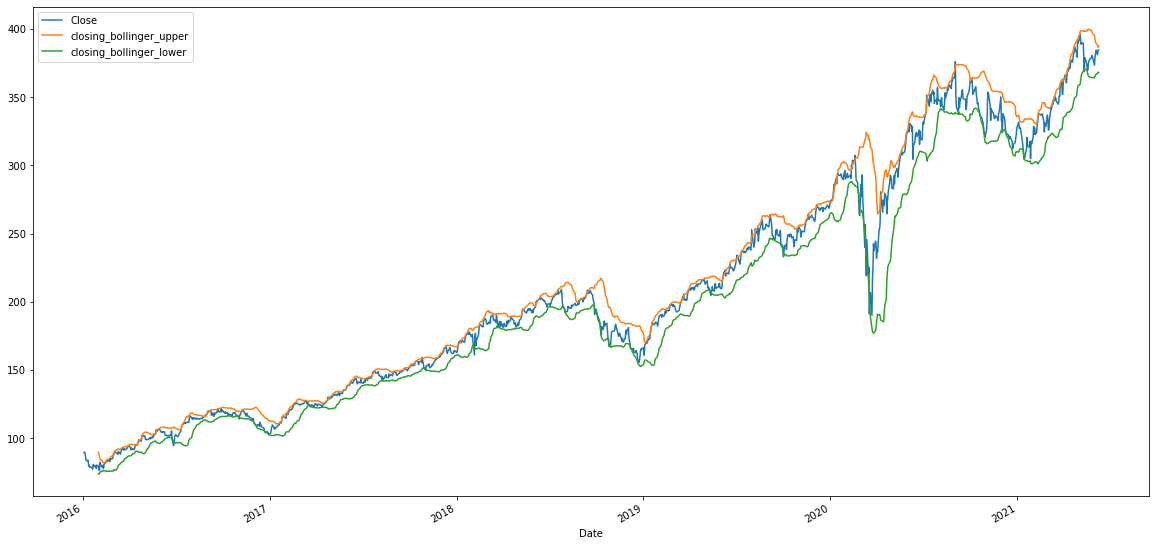

In [389]:
#Bolinger signal

sig_df["closing_rollingmean20"] = sig_df['Close'].rolling(20).mean()
sig_df["closing_rollingstd20"] = sig_df['Close'].rolling(20).std()

sig_df[["Close","closing_rollingmean20", "closing_rollingstd20"]].plot(figsize=(20, 10))

sig_df["closing_bollinger_upper"] = sig_df["closing_rollingmean20"] + (sig_df["closing_rollingstd20"] * 2)
sig_df["closing_bollinger_lower"] = sig_df["closing_rollingmean20"] - (sig_df["closing_rollingstd20"] * 2)

sig_df[["Close","closing_bollinger_upper", "closing_bollinger_lower"]].plot(figsize=(20, 10))


##Buying
sig_df["bollinger_long"] = np.where(sig_df["Close"] < sig_df["closing_bollinger_lower"], 1, 0)

##Selling
sig_df["bollinger_short"] = np.where(sig_df["Close"] > sig_df["closing_bollinger_upper"], -1, 0)


sig_df["bollinger_signal"] = sig_df["bollinger_long"] + sig_df["bollinger_short"]



sig_df

In [390]:

x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
sig_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-06-03,1.0,1.0,0
2021-06-04,1.0,1.0,0
2021-06-07,1.0,1.0,0
2021-06-08,1.0,1.0,0
2021-06-09,1.0,1.0,0


In [391]:
# Shift DataFrame values by 1
sig_df[x_var_list] = sig_df[x_var_list].shift(1)
sig_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2021-06-03,1.0,-1.0,0.0
2021-06-04,1.0,1.0,0.0
2021-06-07,1.0,1.0,0.0
2021-06-08,1.0,1.0,0.0
2021-06-09,1.0,1.0,0.0


In [392]:
# Drop NAs and replace positive/negative infinity values
sig_df.dropna(subset=x_var_list, inplace=True)
sig_df.dropna(subset=['daily_return'], inplace=True)
sig_df = sig_df.replace([np.inf, -np.inf], np.nan)
sig_df.head()

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,crossover_toggle,crossover_real,fast_vol,...,vol_trend_long,vol_trend_short,vol_trend_signal,closing_rollingmean20,closing_rollingstd20,closing_bollinger_upper,closing_bollinger_lower,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,89.795204,0.003375,89.694516,89.649405,1.0,0.0,0.0,1,1.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-06,88.813446,-0.010933,89.191048,89.351230,0.0,-1.0,1.0,1,-1.0,0.010118,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-07,86.019112,-0.031463,87.499348,88.429695,0.0,-1.0,-1.0,2,0.0,0.017562,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-08,83.555260,-0.028643,85.463690,87.315206,0.0,-1.0,-1.0,3,0.0,0.012567,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0
2016-01-11,83.517471,-0.000452,84.475134,86.567738,0.0,-1.0,-1.0,4,0.0,0.017466,...,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0


In [393]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
sig_df['Positive Return'] = np.where(sig_df['daily_return'] > 0, 1.0, 0.0)
sig_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,crossover_toggle,crossover_real,fast_vol,...,vol_trend_short,vol_trend_signal,closing_rollingmean20,closing_rollingstd20,closing_bollinger_upper,closing_bollinger_lower,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,89.795204,0.003375,89.694516,89.649405,1.0,0.0,0.0,1,1.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,1.0
2016-01-06,88.813446,-0.010933,89.191048,89.351230,0.0,-1.0,1.0,1,-1.0,0.010118,...,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-07,86.019112,-0.031463,87.499348,88.429695,0.0,-1.0,-1.0,2,0.0,0.017562,...,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-08,83.555260,-0.028643,85.463690,87.315206,0.0,-1.0,-1.0,3,0.0,0.012567,...,0.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-11,83.517471,-0.000452,84.475134,86.567738,0.0,-1.0,-1.0,4,0.0,0.017466,...,-1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,381.350006,0.004002,379.739307,377.260469,1.0,0.0,1.0,2,0.0,0.011947,...,0.0,-1.0,378.379204,6.033103,390.445409,366.312999,0,0,0.0,1.0
2021-06-04,384.579987,0.008470,382.159647,377.750635,1.0,0.0,1.0,3,0.0,0.008823,...,0.0,1.0,378.169272,5.716958,389.603187,366.735356,0,0,0.0,1.0
2021-06-07,381.230011,-0.008711,381.694829,377.983638,1.0,0.0,1.0,4,0.0,0.011156,...,0.0,1.0,377.734956,5.071027,387.877009,367.592903,0,0,0.0,0.0


In [394]:
# Construct training start and end dates
training_start = sig_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2019-01-01'

# Construct testing start and end dates
testing_start =  '2019-01-02'
#testing_end = sig_df.index.max().strftime(format= '%Y-%m-%d')
testing_end = '2020-01-01'

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2016-01-05
Training End: 2019-01-01
Testing Start: 2019-01-02
Testing End: 2020-01-01


In [395]:
# Construct the X_train and y_train datasets
X_train = sig_df[x_var_list][training_start:training_end]
y_train = sig_df['Positive Return'][training_start:training_end]

X_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2018-12-24,-1.0,1.0,0.0
2018-12-26,-1.0,1.0,0.0
2018-12-27,-1.0,-1.0,0.0
2018-12-28,-1.0,-1.0,0.0
2018-12-31,-1.0,-1.0,0.0


In [396]:
y_train.tail()

Date
2018-12-24    0.0
2018-12-26    1.0
2018-12-27    1.0
2018-12-28    0.0
2018-12-31    1.0
Name: Positive Return, dtype: float64

In [397]:
# Construct the X test and y test datasets
X_test = sig_df[x_var_list][testing_start:testing_end]
y_test = sig_df['Positive Return'][testing_start:testing_end]

X_test.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2019-12-24,1.0,1.0,0.0
2019-12-26,1.0,1.0,0.0
2019-12-27,1.0,1.0,0.0
2019-12-30,1.0,1.0,0.0
2019-12-31,1.0,1.0,0.0


In [398]:
y_test.tail()

Date
2019-12-24    1.0
2019-12-26    1.0
2019-12-27    1.0
2019-12-30    0.0
2019-12-31    1.0
Name: Positive Return, dtype: float64

In [399]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [400]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2019-01-02,0.0,1.0
2019-01-03,0.0,1.0
2019-01-04,1.0,1.0
2019-01-07,1.0,1.0
2019-01-08,1.0,1.0
...,...,...
2019-12-24,1.0,1.0
2019-12-26,1.0,1.0
2019-12-27,1.0,1.0


<AxesSubplot:xlabel='Date'>

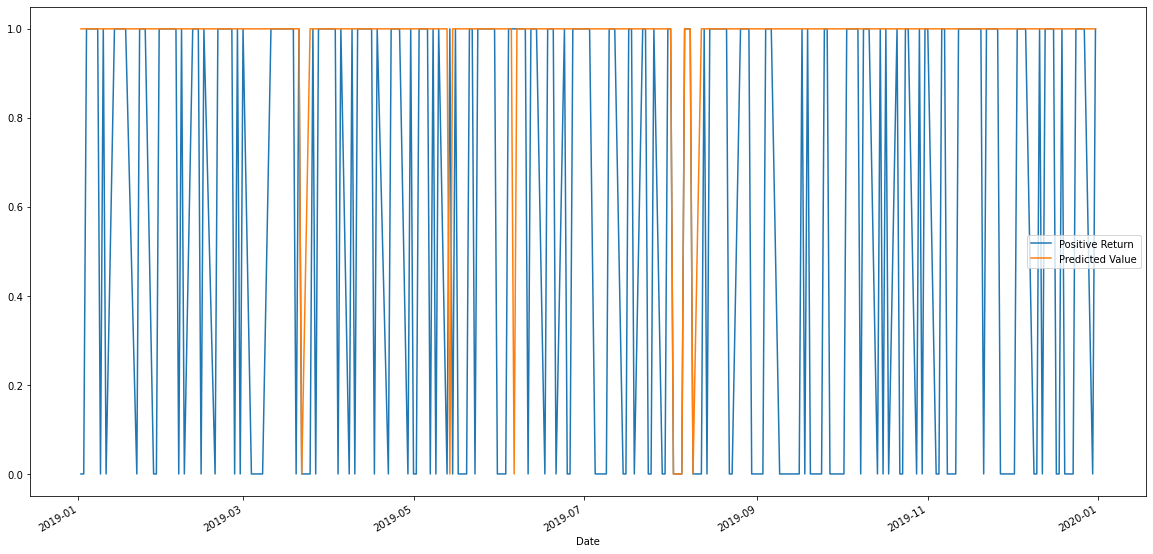

In [401]:
Results.plot(figsize=(20, 10))

<AxesSubplot:xlabel='Date'>

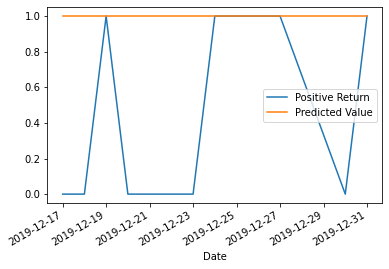

In [402]:
Results[['Positive Return', 'Predicted Value']].tail(10).plot()

In [403]:

# Replace predicted values 0 to -1 to account for shorting
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Positive Return,Predicted Value
Date,,
2019-01-02,0.0,1.0
2019-01-03,0.0,1.0
2019-01-04,1.0,1.0
2019-01-07,1.0,1.0
2019-01-08,1.0,1.0
...,...,...
2019-12-24,1.0,1.0
2019-12-26,1.0,1.0
2019-12-27,1.0,1.0


In [404]:
Results["Returns"] = sig_df['daily_return']

Results

,Positive Return,Predicted Value,Returns
Date,,,
2019-01-02,0.0,1.0,-0.000530
2019-01-03,0.0,1.0,-0.032264
2019-01-04,1.0,1.0,0.048001
2019-01-07,1.0,1.0,0.008011
2019-01-08,1.0,1.0,0.009157
...,...,...,...
2019-12-24,1.0,1.0,0.004164
2019-12-26,1.0,1.0,0.003890
2019-12-27,1.0,1.0,0.002668


<AxesSubplot:xlabel='Date'>

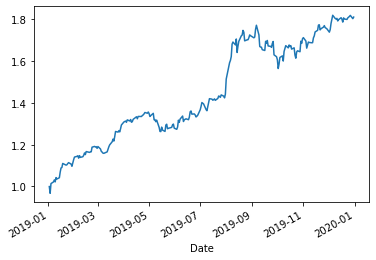

In [405]:

# Calculate cumulative return of model and plot the result
(1 + (Results['Returns'] * Results['Predicted Value'])).cumprod().plot()

<AxesSubplot:xlabel='Date'>

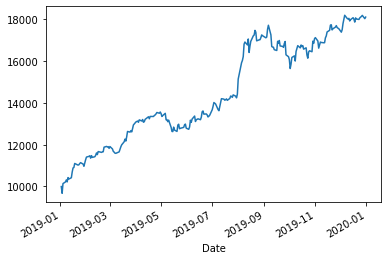

In [406]:
# Set initial capital allocation
initial_capital = 10000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Returns'] * Results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()

<AxesSubplot:xlabel='Date'>

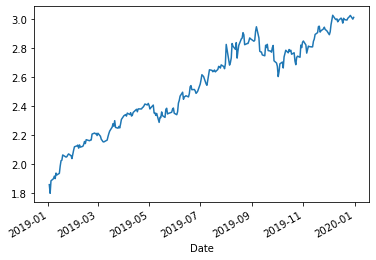

In [407]:
#Actual returns
cumulative_returns['SPGI'].loc['2019-01-01':'2020-01-01'].plot()

<AxesSubplot:xlabel='Date'>

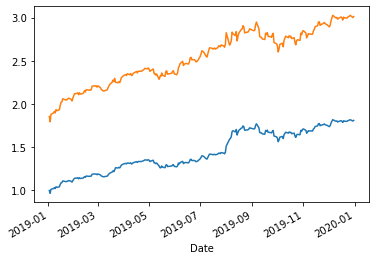

In [408]:
#Compared
(1 + (Results['Returns'] * Results['Predicted Value'])).cumprod().plot()
cumulative_returns['SPGI'].loc['2019-01-01':'2020-01-01'].plot()

In [409]:
#cumulative_returns.hvplot(label='Cumulative Returns', xlabel='Year', ylabel='Percent', height=800, width=1600)

In [410]:
x_values = [1,2,3]
y_values = [1,5,25]

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.8709677419354838


In [411]:
sig_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,crossover_toggle,crossover_real,fast_vol,...,vol_trend_short,vol_trend_signal,closing_rollingmean20,closing_rollingstd20,closing_bollinger_upper,closing_bollinger_lower,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,89.795204,0.003375,89.694516,89.649405,1.0,0.0,0.0,1,1.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,1.0
2016-01-06,88.813446,-0.010933,89.191048,89.351230,0.0,-1.0,1.0,1,-1.0,0.010118,...,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-07,86.019112,-0.031463,87.499348,88.429695,0.0,-1.0,-1.0,2,0.0,0.017562,...,0.0,0.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-08,83.555260,-0.028643,85.463690,87.315206,0.0,-1.0,-1.0,3,0.0,0.012567,...,0.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
2016-01-11,83.517471,-0.000452,84.475134,86.567738,0.0,-1.0,-1.0,4,0.0,0.017466,...,-1.0,1.0,NaN,NaN,NaN,NaN,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,381.350006,0.004002,379.739307,377.260469,1.0,0.0,1.0,2,0.0,0.011947,...,0.0,-1.0,378.379204,6.033103,390.445409,366.312999,0,0,0.0,1.0
2021-06-04,384.579987,0.008470,382.159647,377.750635,1.0,0.0,1.0,3,0.0,0.008823,...,0.0,1.0,378.169272,5.716958,389.603187,366.735356,0,0,0.0,1.0
2021-06-07,381.230011,-0.008711,381.694829,377.983638,1.0,0.0,1.0,4,0.0,0.011156,...,0.0,1.0,377.734956,5.071027,387.877009,367.592903,0,0,0.0,0.0


In [412]:
#Data Reading 
sig_df = pd.DataFrame(index=etf_returns.index)

#Target and Predictor Features 
rsig_df = sig_df.pct_change(1)
rsig_df.columns = ['rsig_df']
rsig_df1 = rsig.shift(1)
rsig_df1.columns = ['rsig1_df']
rsig_dfall = rsig_df
rsig_dfall = rsig_df.join(rsig_df1)
rsig_dfall = rsig_df.dropna()

#Training testing Date Ranges 
rsig_dft = risg_dfall['2016-01-01': '2020-01-01']
rsig_dff = rsig_dfall['2020-01-01': '2021-01-01']

#Random Forest Regression
rft1 = ml.RandomForestRegressor(n_estimators=1, criterion='mse', max_depth=1, max_features=1, bootstrap=True).fit(np.array(rsig_dft['rsig_df1']).reshape(-1,1), rsig_df['rsig_df'])

rft2 =  ml.RandomForestRegressor(n_estimators=2, criterion='mse', max_depth=1, max_features=1, bootstrap=True).fit(np.array(rsig_dft['rsig_df1']).reshape(-1,1), rsig_df['rsig_df'])

#Random Forest Regression Fitting Score
rfts1 = rft1.score(np.array(rsig_dft['rsig_df1']).reshape(-1,1), rsig_df['rsig_df'])
rfts2 = rft2.score(np.array(rsig_dft['rsig_df1']).reshape(-1,1), rsig_df['rsig_df'])
print('')
print('== Random Forest Regression Score ==')
print('')
print('Decision Trees: 1, Score:', np.round(rfts1, 4))
print('Decision Trees: 2, Score:', np.round(rfts2, 4))

ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

# ROUGHWORK
# Pick Model
# ARIMA MODEL

In [294]:
def getCovidData(csv):
    
    csvpath = Path('Resources/COVID_Data/' + csv)
    data = pd.read_csv(csvpath, index_col="Day")
    
    cleaned_data = data.loc[data['Code'] == 'USA'].drop(columns=['Entity', 'Code'])
    
    return cleaned_data

In [295]:
testing_pol = getCovidData('covid-19-testing-policy.csv')
contact_tr = getCovidData('covid-contact-tracing.csv')
vax_pol = getCovidData('covid-vaccination-policy.csv')
debt_relief = getCovidData('debt-relief-covid.csv')
face_cover = getCovidData('face-covering-policies-covid.csv')
income_support = getCovidData('income-support-covid.csv')
internal_mov = getCovidData('internal-movement-covid.csv')
int_travel = getCovidData('international-travel-covid.csv')
public_camp = getCovidData('public-campaigns-covid.csv')
public_events = getCovidData('public-events-covid.csv')
public_gather = getCovidData('public-gathering-rules-covid.csv')
public_trans = getCovidData('public-transport-covid.csv')
stay_home = getCovidData('stay-at-home-covid.csv')
work_close = getCovidData('workplace-closures-covid.csv')
school_close = getCovidData('school-closures-covid.csv')
stringency = getCovidData('covid-stringency-index.csv')

covid_data = pd.concat([testing_pol, contact_tr, vax_pol, debt_relief, face_cover, income_support, internal_mov,
                       int_travel, public_camp, public_events, public_gather, public_trans, stay_home, work_close,
                       school_close, stringency
                       ], axis="columns", join="outer")


covid_data

,testing_policy,contact_tracing,vaccination_policy,debt_relief,facial_coverings,income_support,restrictions_internal_movements,international_travel_controls,public_information_campaigns,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,workplace_closures,school_closures,stringency_index
Day,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-19,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31
2021-05-20,3,1,5,1,4,1,1,3,2,1,4,1,1,1,1.0,52.31


In [296]:
covid_data.isnull().sum()

testing_policy                      0
contact_tracing                     0
vaccination_policy                  0
debt_relief                         0
facial_coverings                    0
income_support                      0
restrictions_internal_movements     0
international_travel_controls       0
public_information_campaigns        0
cancel_public_events                0
restriction_gatherings              0
close_public_transport              0
stay_home_requirements              0
workplace_closures                  0
school_closures                    20
stringency_index                   20
dtype: int64

In [297]:
#Replace nulls with 0s, in this case Null values are where there is either no data or N/A hence, 0.
covid_data['school_closures'] = covid_data['school_closures'].fillna(0)
covid_data['stringency_index'] = covid_data['stringency_index'].fillna(0)

In [298]:
covid_data.isnull().sum()

testing_policy                     0
contact_tracing                    0
vaccination_policy                 0
debt_relief                        0
facial_coverings                   0
income_support                     0
restrictions_internal_movements    0
international_travel_controls      0
public_information_campaigns       0
cancel_public_events               0
restriction_gatherings             0
close_public_transport             0
stay_home_requirements             0
workplace_closures                 0
school_closures                    0
stringency_index                   0
dtype: int64

In [341]:
covid_data

,testing_policy,contact_tracing,vaccination_policy,debt_relief,facial_coverings,income_support,restrictions_internal_movements,international_travel_controls,public_information_campaigns,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,workplace_closures,school_closures,stringency_index
Day,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2021-05-19,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2021-05-20,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1


In [342]:
covid_data.iloc[0]

testing_policy                     0
contact_tracing                    0
vaccination_policy                 0
debt_relief                        0
facial_coverings                   0
income_support                     0
restrictions_internal_movements    0
international_travel_controls      0
public_information_campaigns       0
cancel_public_events               0
restriction_gatherings             0
close_public_transport             0
stay_home_requirements             0
workplace_closures                 0
school_closures                    0
stringency_index                   0
Name: 2020-01-01, dtype: int64

In [ ]:
 
#Covid for one year 

In [ ]:
# Train Test SPlit

In [ ]:
# Linear regression 

In [ ]:
# rf.predict(X_test)

In [343]:
#R squared 

In [344]:
covid_data.replace(to_replace=['no', 'yes'], value=[0, 1])

,testing_policy,contact_tracing,vaccination_policy,debt_relief,facial_coverings,income_support,restrictions_internal_movements,international_travel_controls,public_information_campaigns,cancel_public_events,restriction_gatherings,close_public_transport,stay_home_requirements,workplace_closures,school_closures,stringency_index
Day,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2021-05-19,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2021-05-20,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1


In [345]:
pd.Series(map(lambda x: dict(yes= < 1, no= > 1 )[x],
            covid_data.values.tolist()), covid_data.index)

SyntaxError: invalid syntax (<ipython-input-345-9ff4923d4f5c>, line 1)

# Stanard Scaler ( choice of data standardacy )
# Accuracy Scale 
## Choice of Data Scaling 
# minimum viable product 
# YAML- use when you hard code 

# Plot closing price
df.close.plot()
# Exponentially-Weighted Moving Average -this is for the ML Model 
df.close.ewm(halflife=10).mean().plot()


# Movig Avg on closg price and Exponentially-Weighted Moving Average could be for covid

# hyperparameters 


# Its going to be a continos number whch is regression . It will be Random forest . Linear regression works well for simple data so we are going to do Random forest 

# Pass in a dictionary and set what moving average you wnat to choose and weighted moving average and tweek the base model

# based on Feature importance selection choose top 10 . x train will ave 10 not 50 

# Take 10 and build the model 

#### Train Test 

#### Pick models

#### ARIMA Model

#### Random Forests

# Bollanger Signals 

# We will have two machine learning models

# We want 2 models, one that will predict if the price will rise (higher than 0.5%), and one that will predict the equivalent drop and then combine both into the trading strategy.
 Also, we want to train and test through time so that the models learn with relevant information.
 Finally, we want to simulate if we started out with $1,000 USD, what we would end up with.

# Finally, we want to simulate if we started out with $1,000 USD,

In [346]:
# Where ‘change’ decreased more than 1
df['negative_poc'] = [1 if val < 1 else 0 for val in covid_data['lag-1_change']]
# Where ‘change’ increased more than 1
df['positive_poc'] = [1 if val > 1 else 0 for val in covid_data['lag-1_change']]
df[['lag-1_change', 'positive_poc', 'negative_poc']].head()

KeyError: 'lag-1_change'

### Resample Time Series Data for the ETF's

In [18]:
# Resample the closing prices to weekly and take the mean
# resample() is like groupby() for datetime
weekly = etf_df['Close'].resample('W').mean()

KeyError: 'Close'

In [19]:
# Plot the weekly average closing prices as a line chart
weekly.plot()

NameError: name 'weekly' is not defined